In [2]:
import sys
sys.path.append("/scratch/gf332/BayesOpt/boa/scripts")

import os

import tensorflow as tf
import tensorflow_probability as tfp

from varz.tensorflow import Vars, minimise_l_bfgs_b, minimise_adam
from stheno.tensorflow import GP, EQ, Delta, Graph, Matern52

import numpy as np
import matplotlib.pyplot as plt

from boa.models.fully_factorized_gp_v2 import FullyFactorizedGPModel
from boa.models.gp import GPModel
from boa.models.gpar_v2 import GPARModel
from boa.models.matrix_factorized_gpar_v2 import MatrixFactorizedGPARModel

from boa.core.gp import GaussianProcess

from dataset_loader import load_dataset
from experiments_v2 import prepare_gpar_data

from sklearn.model_selection import train_test_split

# Test Independent GP Model vs Reference Implementation

In [2]:
# Target function (noise free).
def f(X):
    return (np.sinc(3 * X) + 0.5 * (X - 0.5)**2).reshape(-1, 1)


# Generate X's and Y's for training.
np.random.seed(42)
X_train = np.array([
    -0.25,
    0,
    0.1,
]).reshape(-1, 1)
Y_train = f(X_train)

In [3]:
# Setup GP model and train.
model = GPModel(kernel='rbf', num_optimizer_restarts=3)
model.set_data(X_train, Y_train)
model.train()

model_v2 = FullyFactorizedGPModel(kernel='rbf', input_dim=1, output_dim=1, verbose=False)
model_v2.fit(X_train, Y_train, optimizer_restarts=3)

INFO:boa.models.fully_factorized_gp_v2:Training data supplied with xs shape (3, 1) and ys shape (3, 1), training!
INFO:boa.models.fully_factorized_gp_v2:Optimization round: 1 / 3
INFO:boa.models.fully_factorized_gp_v2:Optimization round: 1 / 3
INFO:boa.models.fully_factorized_gp_v2:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp_v2:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp_v2:Optimization round: 2 / 3
INFO:boa.models.fully_factorized_gp_v2:Optimization round: 2 / 3
INFO:boa.models.fully_factorized_gp_v2:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp_v2:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp_v2:Optimization round: 3 / 3
INFO:boa.models.fully_factorized_gp_v2:Optimization round: 3 / 3
INFO:boa.models.fully_factorized_gp_v2:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp_v2:New best objectiv

INFO:boa.models.fully_factorized_gp_v2:GPs haven't been cached yet, creating them now.
INFO:boa.models.fully_factorized_gp_v2:GPs haven't been cached yet, creating them now.


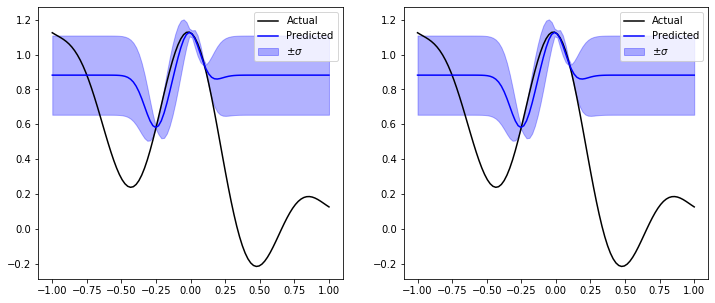

In [4]:
x_candidates = np.linspace(-1, 1, 100).reshape([-1, 1])

pred_mean, pred_var = model.predict_batch(x_candidates)

model_v2 = model_v2.condition_on(X_train, Y_train)
pred_mean_v2, pred_var_v2 = model_v2.predict(x_candidates)

pred_mean_v2 =  pred_mean_v2.numpy()
pred_var_v2 = pred_var_v2.numpy()

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean + np.sqrt(pred_var)).T[0], (pred_mean - np.sqrt(pred_var)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.subplot(122)
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean_v2, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean_v2 + np.sqrt(pred_var_v2)).T[0], (pred_mean_v2 - np.sqrt(pred_var_v2)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.show()

# Test GP, GPAR and MF-GPAR implementations in 1-D

In [2]:
# Test function
def f(x):
    return np.sinc(3 * x[:, 0]).reshape(-1, 1)

# Set seed for reproducibility
np.random.seed(42)

# Generate input data
x_train = np.random.rand(8, 2) * 2 - 1
pseudo_point = np.array([[0.8, 0.3]])
x_train = np.vstack([x_train, pseudo_point])

y_train = f(x_train)

# Points for plotting
x_cont = np.arange(-1.5, 1.5, 0.02).reshape(-1, 1)
x_cont = np.hstack([x_cont, x_cont])

In [1]:
# FF-GP model
ff_gp = FullyFactorizedGPModel(kernel='rbf', 
                               input_dim=2, 
                               output_dim=1, 
                               verbose=False, 
                               initialization_heuristic="dim_median")

ff_gp.fit(x_train, y_train, optimizer_restarts=1)
ff_gp = ff_gp.condition_on(x_train, y_train)

y_pred_ff_gp, var_pred_ff_gp = ff_gp.predict(x_cont)

y_pred_ff_gp = y_pred_ff_gp.numpy()
var_pred_ff_gp = var_pred_ff_gp.numpy()

NameError: name 'FullyFactorizedGPModel' is not defined

In [4]:
# GPAR model
gpar = GPARModel(kernel='rbf', 
                 input_dim=2, 
                 output_dim=1, 
                 verbose=False, 
                 initialization_heuristic="dim_median")

gpar.fit(x_train, y_train, optimizer_restarts=1)
gpar = gpar.condition_on(x_train, y_train)

y_pred_gpar, var_pred_gpar = gpar.predict(x_cont)

y_pred_gpar = y_pred_gpar.numpy()
var_pred_gpar = var_pred_gpar.numpy()

INFO:boa.models.gpar_v2:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.gpar_v2:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
DEBUG:boa.models.gpar_v2:Creating hyperparameters!
DEBUG:boa.models.gpar_v2:Creating hyperparameters!
DEBUG:boa.models.gpar_v2:Reinitializing hyperparameters with length scale init mode: dim_median.
DEBUG:boa.models.gpar_v2:Reinitializing hyperparameters with length scale init mode: dim_median.
INFO:boa.models.gpar_v2:Output 0, Iteration 1: New best loss: 11.400
INFO:boa.models.gpar_v2:Output 0, Iteration 1: New best loss: 11.400
INFO:boa.models.gpar_v2:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar_v2:GPs haven't been cached yet, creating them now.


In [10]:
mf_gpar = MatrixFactorizedGPARModel(kernel='rbf', 
                                    latent_dim=1,
                                    input_dim=2, 
                                    output_dim=1, 
                                    verbose=False, 
                                    initialization_heuristic="median")

mf_gpar.fit(x_train, y_train, optimizer_restarts=10)

#mf_gpar.add_pseudo_point(pseudo_point)
y_pred_mf_gpar, var_pred_mf_gpar = mf_gpar.predict(x_cont)

y_pred_mf_gpar = y_pred_mf_gpar.numpy()
var_pred_mf_gpar = var_pred_mf_gpar.numpy()

INFO:boa.models.matrix_factorized_gpar_v2:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.matrix_factorized_gpar_v2:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.gpar_v2:GPs haven't been cached yet, creating them now.
INFO:boa.models.gpar_v2:GPs haven't been cached yet, creating them now.


 /scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


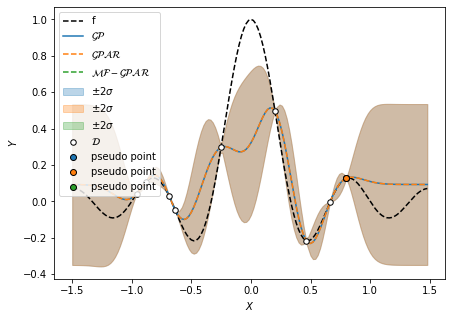

In [16]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

# Ground truth
ax.plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax.plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{GP}$')
ax.fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax.plot(x_cont[:, 0], y_pred_gpar, color='C1', zorder=-1, label=r'$\mathcal{GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# # MF-GPAR predictions
ax.plot(x_cont[:, 0], y_pred_mf_gpar, color='C2', zorder=-1, label=r'$\mathcal{MF-GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_mf_gpar + 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                (y_pred_mf_gpar - 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                color='C2',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Data points
ax.scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax.scatter(x=pseudo_point[:, 0], y=ff_gp.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=gpar.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=mf_gpar.predict(pseudo_point)[0][0], c='C2', edgecolors='black', label='pseudo point')

ax.legend(loc='upper left')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

fig.show()

# Test saving

In [2]:
ff_gp_save_path = "models/ff_gp/gp1"

ff_gp.save(ff_gp_save_path)

ff_gp_ = FullyFactorizedGPModel.restore(ff_gp_save_path)

y_pred_ff_gp_, var_pred_ff_gp_ = ff_gp_.predict(x_cont)

y_pred_ff_gp_ = y_pred_ff_gp_.numpy()
var_pred_ff_gp_ = var_pred_ff_gp_.numpy()

gpar_save_path = "models/gpar/gp1"

gpar.save(gpar_save_path)

gpar_ = GPARModel.restore(gpar_save_path)

y_pred_gpar_, var_pred_gpar_ = gpar_.predict(x_cont)

y_pred_gpar_ = y_pred_gpar_.numpy()
var_pred_gpar_ = var_pred_gpar_.numpy()

NameError: name 'ff_gp' is not defined

 /scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


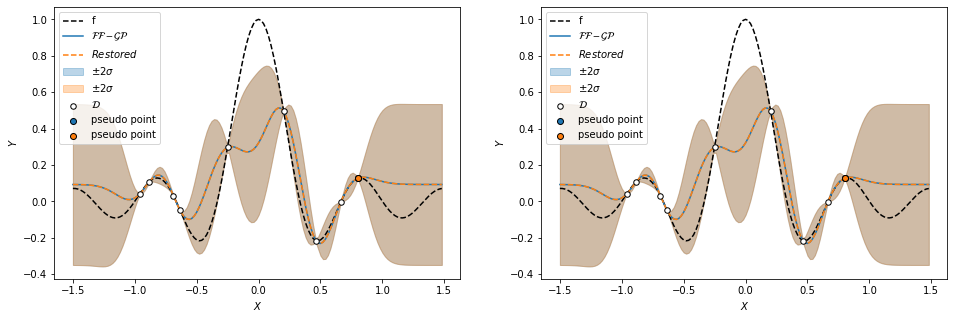

In [6]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Ground truth
ax[0].plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax[0].plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax[0].fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Restored predictions
ax[0].plot(x_cont[:, 0], y_pred_ff_gp_, color='C1', zorder=-1, label=r'$Restored$', linestyle='dashed')
ax[0].fill_between(x_cont.T[0],
                (y_pred_ff_gp_ + 2 * np.sqrt(var_pred_ff_gp_)).T[0],
                (y_pred_ff_gp_ - 2 * np.sqrt(var_pred_ff_gp_)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax[0].scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax[0].scatter(x=pseudo_point[:, 0], y=ff_gp.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax[0].scatter(x=pseudo_point[:, 0], y=ff_gp_.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')

ax[0].legend(loc='upper left')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

# Ground truth
ax[1].plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax[1].plot(x_cont[:, 0], y_pred_gpar, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax[1].fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax[1].plot(x_cont[:, 0], y_pred_gpar_, color='C1', zorder=-1, label=r'$Restored$', linestyle='dashed')
ax[1].fill_between(x_cont.T[0],
                (y_pred_gpar_ + 2 * np.sqrt(var_pred_gpar_)).T[0],
                (y_pred_gpar_ - 2 * np.sqrt(var_pred_gpar_)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax[1].scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax[1].scatter(x=pseudo_point[:, 0], y=gpar.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax[1].scatter(x=pseudo_point[:, 0], y=gpar_.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')

ax[1].legend(loc='upper left')
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('$Y$')

fig.show()

# GPAR Cholesky problems

In [3]:
# FFT dataset
fft_data_path = "../resources/fft_dataset.csv"

data = load_dataset(fft_data_path, "fft")
df, input_labels, output_labels = prepare_gpar_data(data, ["avg_power", "cycle", "total_area"])

train, test = train_test_split(df,
                               train_size=25,
                              test_size=200,
                              random_state=42)

x_train = tf.convert_to_tensor(train[input_labels].values, dtype=tf.float64)
y_train = tf.convert_to_tensor(train[output_labels].values, dtype=tf.float64)

x_mean, x_var = tf.nn.moments(x_train, axes=[0])
y_mean, y_var = tf.nn.moments(y_train, axes=[0])

x_std = tf.maximum(tf.sqrt(x_var), 1e-6)
y_std = tf.maximum(tf.sqrt(y_var), 1e-6)

# Test Matrix Factorized GPAR

In [4]:
ff_gp = FullyFactorizedGPModel.restore("../models/exceptions/gp_model/model")

In [6]:
gp.jitter

GP([7.92526937e-07] * Delta(), 0)

In [5]:
gp = ff_gp.models[0]
gp_ = gp.copy()

In [10]:
x_test = ff_gp._validate_and_convert(test[input_labels].values)

In [23]:
tf.linalg.eigh(gp.signal.kernel.K_z.mat)[0]

<tf.Tensor: id=6318, shape=(50,), dtype=float64, numpy=
array([-4.86630897e-11,  5.79395380e-05,  1.80064644e-04,  2.00933139e-04,
        3.29863820e-04,  3.63071999e-04,  5.95673917e-04,  7.52053994e-04,
        1.04188212e-03,  1.43959498e-03,  1.77186728e-03,  1.85402512e-03,
        1.85421374e-03,  2.36634645e-03,  2.54274415e-03,  3.96516257e-03,
        4.54339354e-03,  4.61561842e-03,  6.54709242e-03,  6.94573211e-03,
        7.86546423e-03,  1.05208033e-02,  1.09612965e-02,  1.47148130e-02,
        1.59695284e-02,  1.83315717e-02,  2.18757293e-02,  2.58900581e-02,
        3.34069822e-02,  4.47649840e-02,  4.96634592e-02,  5.29215188e-02,
        5.72784457e-02,  6.02191522e-02,  7.71591820e-02,  1.03241142e-01,
        1.56546454e-01,  1.83456120e-01,  2.22790996e-01,  3.35727140e-01,
        3.48999330e-01,  6.07582101e-01,  7.80989328e-01,  7.86514399e-01,
        1.21382704e+00,  1.21458108e+00,  6.01894027e+00,  7.09858334e+00,
        3.16895861e+01,  3.95663034e+01])>

In [18]:
i = 11
gp = ff_gp.models[i].copy()
gp = gp | (ff_gp.xs, ff_gp.ys[:, i:i+1])
gp.predict(x_test, latent=False)

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [16]:
xs_ = gp.xs_forward_transform(x_test)

In [17]:
tf.nn.moments(xs_, axes=[0])

(<tf.Tensor: id=8787, shape=(18,), dtype=float64, numpy=
 array([-0.11739548,  0.13094623, -0.00625   ,  0.22332198, -0.02355557,
         0.13001267, -0.10001184,  0.13392857,  0.12026179,  0.18131017,
        -0.0125    ,  0.04003204, -0.1145235 , -0.06004806, -0.29796878,
         0.14011213, -0.36443449, -0.23474277])>,
 <tf.Tensor: id=8788, shape=(18,), dtype=float64, numpy=
 array([0.64718853, 1.01450893, 1.25673177, 1.32140737, 1.12107156,
        0.92100272, 0.94549006, 0.96771365, 1.03506381, 1.01095779,
        1.00765625, 1.00160256, 0.88972163, 1.00120192, 0.94144465,
        0.99158654, 1.1484375 , 1.04072917])>)

In [16]:
ff_gp.predict(x_test)

DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

In [27]:
class Heh:
    
    def a(self):
        return self.__class__

class Hah(Heh):
    pass

h = Heh()
h.a()

h = Hah()
x = h.a()

In [30]:
h_ = x()
h_.a()

__main__.Hah